In [1]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D,Wraparound1D,periodic_padding,CustomCallback
from ca_funcs import make_glider, make_game_of_life
import tensorflow as tf
import numpy as np
import random
from train_ca import *
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

Starting...
Data generated


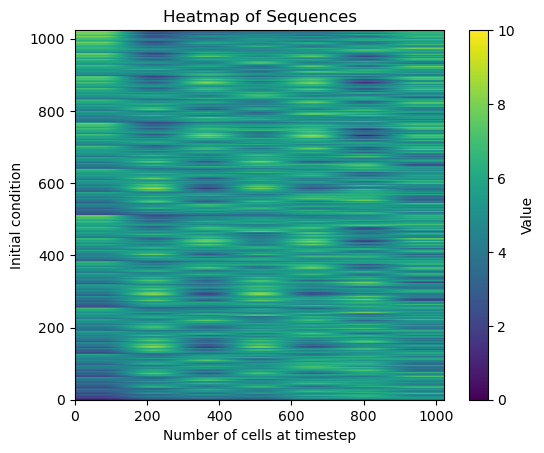

In [70]:
def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length+1,1)
 
 
 
SEED =3
print("Starting...")
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
# 2100 outer totalistic  Generating Data
 
gridsize=10

x_values = [seq for seq in itertools.product("01", repeat=gridsize)]

x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=3
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

gol.set_rule_number(30)

sequences= np.array(gol.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print("Data generated") 

collapsed_sequences=collapse_sequences(sequences)
n = gridsize

#Some visualization of the dataset
plt.imshow(collapsed_sequences[::-1], cmap='viridis', origin='upper',
           extent=[0, collapsed_sequences.shape[0], 0,
                  collapsed_sequences.shape[0]], vmin=0, vmax=n)
plt.colorbar(label='Value')
plt.xlabel("Number of cells at timestep")
plt.ylabel("Initial condition")
plt.title('Heatmap of Sequences')
plt.savefig("Heatmap_rule30")

#sequences=np.concatenate((sequences,sequences),axis=0)
np.random.shuffle(sequences)

x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
y_sequence=sequences[:,MEMORY_CONSTANT*2]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
#might leave it unchanged for binary systems    
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
split_index = round(samples*0.85)
x_train = x_sequence
    
y_train= Y_val_onehot
   

loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),
                                                            tf.reshape(y, shape=(-1, num_classes)) ,from_logits=True)

y_train_full= Y_val_onehot

In [71]:
y_train_full= Y_val_onehot
split_ratio = 0.25
x_train_reshaped=[]
for data_point in x_train:
    x_train_reshaped.append(np.transpose(data_point))
x_train_reshaped=np.array(x_train_reshaped)  
 
split_point_x = int(len(x_train_reshaped) * split_ratio)
split_point_y = int(len(y_train_full) * split_ratio)
 
x_test = x_train_reshaped[:split_point_x]
y_test = y_train_full[:split_point_y]
x_train = x_train_reshaped[split_point_x:]
y_train = y_train_full[split_point_y:]
split_ratio = 0.5
 
split_point_x = int(len(x_test) * split_ratio)
split_point_y = int(len(y_test) * split_ratio)

 
x_val = x_test[:split_point_x]
y_val = y_test[:split_point_x]
x_test = x_test[split_point_x:]
y_test = y_test[split_point_x:]
 
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (768, 10, 3)
y_train shape: (768, 10, 2)
x_val shape: (128, 10, 3)
y_val shape: (128, 10, 2)
x_test shape: (128, 10, 3)
y_test shape: (128, 10, 2)


In [64]:
num_filters=1
kernel_size = MEMORY_CONSTANT
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,MEMORY_CONSTANT,1  )))  
model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid',
                                 kernel_initializer=keras.initializers.ones(), 
                                         bias_initializer=tf.keras.initializers.he_normal(),trainable=True,use_bias=True,
                                 activation="relu"
                                  ))

#model.add(tf.keras.layers.SimpleRNN(units=1, return_sequences=True, activation='relu',
 #                              kernel_initializer=tf.keras.initializers.Ones()))
    
model.add(tf.keras.layers.Reshape((gridsize,1)))
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
model.add(Wraparound1D(padding=1))
model.add(tf.keras.layers.Conv1D(gridsize, 3, activation='relu', padding='valid',  trainable=True) )

model.add(tf.keras.layers.Conv1D(gridsize, 1, activation='relu', padding='same'))
 
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()
x_train_reshaped=[]
 
x_train_reshaped=tf.convert_to_tensor(x_train , dtype=tf.float32)

model.fit(x_train_reshaped, y_train, 
          validation_data=(x_val, y_val)
          ,epochs=4
        , batch_size=1,callbacks=[early_stopping_callback]) 
model.evaluate(x_test,y_test)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_55 (Conv1D)          (None, 10, 1, 1)          4         
                                                                 
 reshape_27 (Reshape)        (None, 10, 1)             0         
                                                                 
 dense_40 (Dense)            (None, 10, 2)             4         
                                                                 
 wraparound1d_15 (Wraparound  (None, 12, 2)            0         
 1D)                                                             
                                                                 
 conv1d_56 (Conv1D)          (None, 10, 10)            70        
                                                                 
 conv1d_57 (Conv1D)          (None, 10, 10)            110       
                                                     

[0.3284611105918884, 1.0]

In [ ]:
output=model.predict(np.array(x_train_reshaped[0]).reshape(-1,10,MEMORY_CONSTANT,1))
binary_sequence = np.argmax(output, axis=-1) 
binary_sequence = binary_sequence.reshape(10)
binary_sequence
 

# Demonstrate Correct ordering

In [76]:
data=x_sequence[0]
print(data)
print(" ")
print(data.reshape(-1,10,3))
print(np.transpose(data))

[[0 1 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 1 1 0]
 [0 1 0 0 0 0 0 1 1 0]]
 
[[[0 1 0]
  [0 0 0]
  [0 0 1]
  [1 1 0]
  [0 0 0]
  [0 0 1]
  [1 0 0]
  [1 0 0]
  [0 0 0]
  [1 1 0]]]
[[0 1 0]
 [1 0 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]
 [1 0 0]]


# Just The Memory

In [61]:

from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D
from ca_funcs import make_glider, make_game_of_life
import tensorflow as tf
import numpy as np
import random
from train_ca import *
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length+1,1)
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
        if logs.get('val_accuracy') == 1:
            self.model.stop_training = True 
 
 
 
SEED =3
print("Starting...")
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
 
gridsize=10
 
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]

x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=3
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

gol.set_rule_number(30)

sequences= np.array(gol.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print("Data generated") 

 
n = gridsize
 
np.random.shuffle(sequences)
y_sequence= []
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
for x in x_sequence:
    y_sequence.append(gol.mostFrequentPastStateBinary(x))
y_sequence=np.array(y_sequence)

x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), 2))
 
x_train = x_sequence
     
y_train_full= Y_val_onehot
split_ratio = 0.25
x_train_reshaped=[]
for data_point in x_train:
    x_train_reshaped.append(np.transpose(data_point))
x_train_reshaped=np.array(x_train_reshaped)  
 
split_point_x = int(len(x_train_reshaped) * split_ratio)
split_point_y = int(len(y_train_full) * split_ratio)

# Split the data into training and test sets
x_test = x_train_reshaped[:split_point_x]
y_test = y_train_full[:split_point_y]
x_train = x_train_reshaped[split_point_x:]
y_train = y_train_full[split_point_y:]
split_ratio = 0.5
# Calculate new split points for the validation set
split_point_x = int(len(x_test) * split_ratio)
split_point_y = int(len(y_test) * split_ratio)

# Split the data into validation and test sets
x_val = x_test[:split_point_x]
y_val = y_test[:split_point_x]
x_test = x_test[split_point_x:]
y_test = y_test[split_point_x:]

# Print the shapes of the resulting sets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

num_filters = 1
kernel_size = MEMORY_CONSTANT

    
memory_horizon=MEMORY_CONSTANT 
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,memory_horizon,1   )))  

model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid',
                                 kernel_initializer=keras.initializers.ones(), 
                                         bias_initializer=keras.initializers.he_normal(),trainable=True,use_bias=True,
                                 activation="relu"
                                
                                  ))

#model.add(tf.keras.layers.SimpleRNN(units=1, return_sequences=True, activation='relu',
 #                              kernel_initializer=tf.keras.initializers.Ones()))

model.add(tf.keras.layers.Reshape((10,1)))
model.add(tf.keras.layers.Dense(units=2, activation="relu" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
                           

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()

x_train_reshaped=tf.convert_to_tensor( np.array(x_train), dtype=tf.float32)
model.fit(x_train_reshaped, y_train, validation_data=(x_val, y_val), epochs=5
        , batch_size=1,callbacks=[early_stopping_callback])
 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting...
Data generated
x_train shape: (768, 10, 3)
y_train shape: (768, 10, 2)
x_val shape: (128, 10, 3)
y_val shape: (128, 10, 2)
x_test shape: (128, 10, 3)
y_test shape: (128, 10, 2)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 10, 1, 1)          4         
                                                                 
 reshape_26 (Reshape)        (None, 10, 1)             0         
                                                                 
 dense_39 (Dense)            (None, 10, 2)             4         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
768/768 [===========================

In [57]:
model.predict(np.array(x_train_reshaped[1]).reshape(-1,10,MEMORY_CONSTANT,1))

1/1 [==============================] - 0s 88ms/step


array([[[1.8603135e-02, 9.8139679e-01],
        [2.5023252e-02, 9.7497672e-01],
        [2.6712804e-03, 9.9732870e-01],
        [2.2408004e-04, 9.9977589e-01],
        [2.1458799e-03, 9.9785411e-01],
        [1.7075086e-01, 8.2924908e-01],
        [1.5388855e-01, 8.4611148e-01],
        [9.5936608e-01, 4.0633913e-02],
        [6.8202716e-01, 3.1797284e-01],
        [9.3384260e-01, 6.6157386e-02]]], dtype=float32)

In [5]:
model.weights

[<tf.Variable 'simple_rnn_1/simple_rnn_cell_1/kernel:0' shape=(7, 1) dtype=float32, numpy=
 array([[1.7054176],
        [1.3982818],
        [1.5009807],
        [1.6137043],
        [1.6683371],
        [1.596241 ],
        [1.7512336]], dtype=float32)>,
 <tf.Variable 'simple_rnn_1/simple_rnn_cell_1/recurrent_kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.0179998]], dtype=float32)>,
 <tf.Variable 'simple_rnn_1/simple_rnn_cell_1/bias:0' shape=(1,) dtype=float32, numpy=array([-2.3864584], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[0.10070134, 1.8992993 ]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([ 3.2918503, -2.3429763], dtype=float32)>]